In [130]:

import pprint
import random
from datetime import datetime, timedelta
import string
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import requests
from colorspacious import cspace_converter
from collections import OrderedDict

In [131]:
## Get state abbrevations

In [132]:
abbrevdf = pd.read_json('state_abbreviations.json')
states = abbrevdf['Code'].to_numpy()
print(states)

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [133]:
## Get covid 19 stats for US and states

In [166]:
#states = ['AL','GA','FL','TN','LA','CA','NY','WA']
response = requests.request("GET",'https://api.covidtracking.com/v1/us/daily.json')
usdf = pd.read_json(response.text)
usdf['date'] = pd.to_datetime(usdf['date'], format='%Y%m%d')

df = pd.DataFrame()
for state in states:
    url='https://api.covidtracking.com/v1/states/{s}/daily.json'.format(s = state.lower())
    response = requests.request("GET", url)
    statedf = pd.read_json(response.text)
    statedf['date'] = pd.to_datetime(statedf['date'], format='%Y%m%d')
    df = pd.concat([df,statedf])
print(df.head())

date state  positive  negative  pending  hospitalizedCurrently  \
0 2020-08-27    AL  121023.0  835786.0      NaN                 1052.0   
1 2020-08-26    AL  119254.0  824431.0      NaN                 1077.0   
2 2020-08-25    AL  117242.0  810035.0      NaN                 1097.0   
3 2020-08-24    AL  116710.0  806609.0      NaN                 1149.0   
4 2020-08-23    AL  115060.0  806609.0      NaN                 1093.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                 14005.0             NaN           1430.0   
1                 14005.0             NaN           1412.0   
2                 13793.0             NaN           1399.0   
3                 13793.0             NaN           1391.0   
4                 13502.0             NaN           1348.0   

   onVentilatorCurrently  ...  posNeg  deathIncrease hospitalizedIncrease  \
0                    NaN  ...  956809             31                    0   
1                    NaN  ...  94368

## Get population data for states

In [167]:
usdf['POPESTIMATE2019'] = 330183381
abbrevdf = pd.read_json('state_abbreviations.json')
popdf = pd.read_csv("scprc-est2019-18+pop-res.csv")
popdf.rename(columns={'NAME': 'State'}, inplace=True)
popdf = popdf.join(abbrevdf.set_index('State'), on='State')
#print(popdf.statedf
#population = popdf.loc[popdf['State'] == 'Alabama']['POPESTIMATE2019']
#print(population)
print(popdf.head())
print("-------------")
print(df.head())
df = df.join(popdf.set_index('Code'), on='state',lsuffix='',rsuffix='pop_')
#df['POPESTIMATE2019'] = df['POPESTIMATE2019'].fillna(0)
df.head()

SUMLEV REGION DIVISION  STATE          State  POPESTIMATE2019  \
0      10      0        0      0  United States        328239523   
1      40      3        6      1        Alabama          4903185   
2      40      4        9      2         Alaska           731545   
3      40      4        8      4        Arizona          7278717   
4      40      3        7      5       Arkansas          3017804   

   POPEST18PLUS2019  PCNT_POPEST18PLUS  Abbrev Code  
0         255200373               77.7     NaN  NaN  
1           3814879               77.8    Ala.   AL  
2            551562               75.4  Alaska   AK  
3           5638481               77.5   Ariz.   AZ  
4           2317649               76.8    Ark.   AR  
-------------
        date state  positive  negative  pending  hospitalizedCurrently  \
0 2020-08-27    AL  121023.0  835786.0      NaN                 1052.0   
1 2020-08-26    AL  119254.0  824431.0      NaN                 1077.0   
2 2020-08-25    AL  117242.0  8100

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,grade,SUMLEV,REGION,DIVISION,STATE,State,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS,Abbrev
0,2020-08-27,AL,121023.0,835786.0,NaN,1052.0,14005.0,NaN,1430.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
1,2020-08-26,AL,119254.0,824431.0,NaN,1077.0,14005.0,NaN,1412.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
2,2020-08-25,AL,117242.0,810035.0,NaN,1097.0,13793.0,NaN,1399.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
3,2020-08-24,AL,116710.0,806609.0,NaN,1149.0,13793.0,NaN,1391.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
4,2020-08-23,AL,115060.0,806609.0,NaN,1093.0,13502.0,NaN,1348.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.


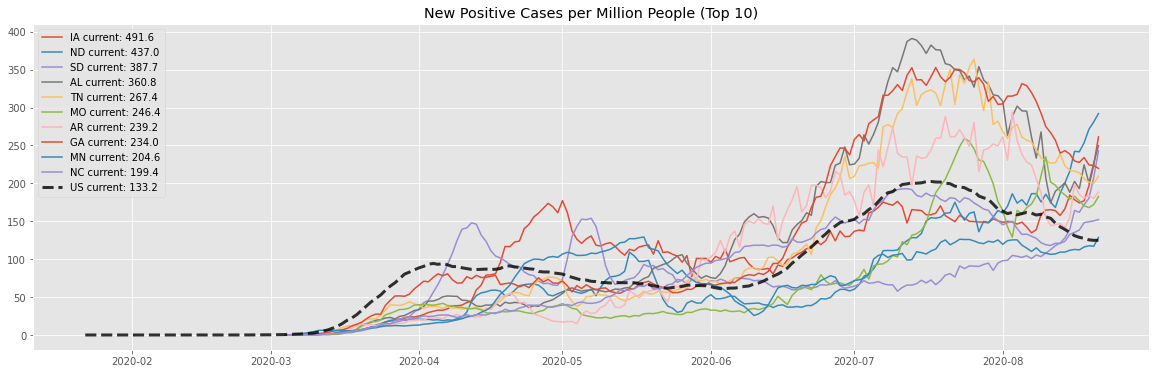

In [168]:
df['popPositiveIncrease'] = df['positiveIncrease'] / df['POPESTIMATE2019'] * 1000000
usdf['popPositiveIncrease'] = usdf['positiveIncrease'] / usdf['POPESTIMATE2019'] * 1000000
plt.style.use('ggplot')
plots = []
labels = []
plt.rcParams["figure.figsize"] = (20,6)
# Get ordered list of states by current popPositiveIncrease
top_states = df.sort_values(by='date').drop_duplicates(subset=['state'], keep='last').sort_values(by='popPositiveIncrease',ascending=False)
for state in top_states['state'].head(10):
    statedf = df[df['state'] == state]
    plot, = plt.plot(statedf['date'],statedf['popPositiveIncrease'].rolling(window=7).mean(),label=state)
    plots.append(plot)
    currentIncrease = statedf.sort_values(by='date').iloc[-1,:].popPositiveIncrease
    labels.append("{} current: {:.1f}".format(state,currentIncrease))
plot, = plt.plot(usdf['date'],usdf['popPositiveIncrease'].rolling(window=7).mean(),label='US',linestyle='--',linewidth=3,color='black',alpha=0.8)
plots.append(plot)
currentIncrease = usdf.sort_values(by='date').iloc[-1,:].popPositiveIncrease
labels.append("{} current: {:.1f}".format('US',currentIncrease))
plt.legend(handles=plots, labels=labels,loc='upper left')
plt.title('New Positive Cases per Million People (Top 10)')
plt.show()